## Проект "Анализ данных"
### Рыжих Владислав

В данной работе мы сделаем небольшой анализ данных и построим модель, которая мы предсказывала годовую оценку

In [198]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Сперва загрузим наши данные в dataFrame. И сделаем так, чтобы отображались все столбцы

In [200]:
df = pd.read_csv('student-por.csv')
pd.options.display.max_columns = 60
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


Так как мы хотим по итогу построить модель, которая бы предсказывала итоговую оценку за курс, то нам следует исключить столбцы, которые показывают оценки по семестрам. Делаем мы это просто для интереса, чтобы модель при подборе оценки за год делала свой выбор не просто посчитав ср арифм по G1 и G2 :) 

In [201]:
df.drop(['G1', 'G2'], axis=1, inplace=True)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,13


Найдем тип каждой переменной наших данных

In [136]:
df.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G3             int64
dtype: object

In [152]:
df['G3'].describe()

count    649.000000
mean      11.906009
std        3.230656
min        0.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: G3, dtype: float64

Text(0, 0.5, 'Number of marks')

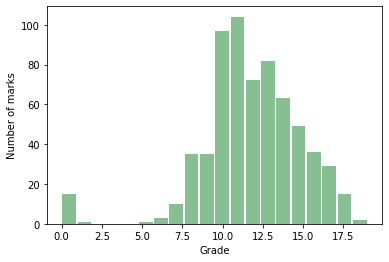

In [170]:
d = df['G3'].hist(grid=False, color='#86bf91', rwidth=0.9, bins=20)
d.set_xlabel('Grade')
d.set_ylabel('Number of marks')

Из гистограммы видно, что больше всего студентов набрало 10-11 баллов. При этом 15 человек получили 0 по итогу за курс. Средняя оценка 11.9, при том, что никто не набрал максимальный балл.

Построим таблицу зависимости оценок от места проживания (R - сельский, U - городской)

In [171]:
df.groupby('address')['G3'].mean()

address
R    11.086294
U    12.263274
Name: G3, dtype: float64

Из таблицы выше видно, что у городских средний балл выше примерно на 1 балл, чем у сельских.

Переведем стринговые значиния во флаги

In [202]:
df_for_analysis = pd.get_dummies(df, prefix=['address'], columns=['address'])
df_for_analysis.head()

,school,sex,age,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3,address_R,address_U
0,GP,F,18,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,11,0,1
1,GP,F,17,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,11,0,1
2,GP,F,15,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,0,1
3,GP,F,15,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,0,1
4,GP,F,16,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,13,0,1


In [157]:
df_for_corr = df_for_analysis[['G3','address_R', 'address_U']]
df_for_corr.corr()
corr = df_for_corr.corr()
corr.style.background_gradient()

,G3,address_R,address_U
G3,1,-0.167637,0.167637
address_R,-0.167637,1,-1
address_U,0.167637,-1,1


In [159]:
df.groupby('sex')['G3'].mean()

sex
F    12.253264
M    11.406015
Name: G3, dtype: float64

Из таблицы выше мы можем сделать вывод, что девушки, в среднем, сдают экзамены лучше парней

In [203]:
df_for_analysis = pd.get_dummies(df, prefix=['sex'], columns=['sex'])
df_for_corr = df_for_analysis[['G3','sex_M', 'sex_F']]
df_for_corr.corr()
corr = df_for_corr.corr()
corr.style.background_gradient()

,G3,sex_M,sex_F
G3,1,-0.129077,0.129077
sex_M,-0.129077,1,-1
sex_F,0.129077,-1,1


In [173]:
corr = df.corr()
corr.style.background_gradient()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3
age,1,-0.107832,-0.12105,0.03449,-0.00841511,0.319968,-0.0205595,-0.00491026,0.112805,0.134768,0.0863573,-0.00875012,0.149998,-0.106505
Medu,-0.107832,1,0.647477,-0.265079,0.0970058,-0.17221,0.0244206,-0.0196863,0.00953649,-0.00701832,-0.0197658,0.00461406,-0.00857749,0.240151
Fedu,-0.12105,0.647477,1,-0.208288,0.0503996,-0.165915,0.0202559,0.00684063,0.0276897,6.07749e-05,0.0384447,0.0449098,0.0298587,0.2118
traveltime,0.03449,-0.265079,-0.208288,1,-0.0631539,0.0977298,-0.00952118,0.000936734,0.0574542,0.0928243,0.0570072,-0.0482612,-0.00814909,-0.127173
studytime,-0.00841511,0.0970058,0.0503996,-0.0631539,1,-0.147441,-0.00412713,-0.0688292,-0.0754422,-0.137585,-0.214925,-0.0564327,-0.118389,0.249789
failures,0.319968,-0.17221,-0.165915,0.0977298,-0.147441,1,-0.0626452,0.108995,0.0450778,0.105949,0.0822663,0.0355882,0.122779,-0.393316
famrel,-0.0205595,0.0244206,0.0202559,-0.00952118,-0.00412713,-0.0626452,1,0.129216,0.0897066,-0.0757672,-0.0935108,0.109559,-0.0895337,0.0633611
freetime,-0.00491026,-0.0196863,0.00684063,0.000936734,-0.0688292,0.108995,0.129216,1,0.346352,0.109904,0.120244,0.0845264,-0.018716,-0.122705
goout,0.112805,0.00953649,0.0276897,0.0574542,-0.0754422,0.0450778,0.0897066,0.346352,1,0.245126,0.38868,-0.0157411,0.0853738,-0.0876407
Dalc,0.134768,-0.00701832,6.07749e-05,0.0928243,-0.137585,0.105949,-0.0757672,0.109904,0.245126,1,0.616561,0.0590675,0.172952,-0.204719


Так как модели не особо умеют работать со стрингами, нам надо перевести все данные в числовые значения

In [204]:
df1 = pd.get_dummies(df)

In [205]:
y = df1[['G3']]
X = df1.drop(['G3'], axis=1)

Так как тренировать и текстировать модель на одних и тех же данных идея не из лучших, то мы разделим наши данные

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [223]:
dt = RandomForestRegressor(random_state=0, criterion="mae")
dt_fit = dt.fit(X_train, y_train)

dt_scores = cross_val_score(dt_fit, X_train, y_train, cv = 10)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(dt_fit.score(X_train, y_train)))

# on the test or hold-out set
print(r2_score(y_test, dt_fit.predict(X_test)))
print(dt_fit.score(X_test, y_test))

/Users/vladislavryzhikh/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


mean cross validation score: 0.1646994160694651
score without cv: 0.849875877150663
0.05770140601052853
0.05770140601052853


In [219]:
y_train = y_train['G3']

In [222]:
scoring = make_scorer(r2_score)
g_cv = GridSearchCV(RandomForestRegressor(random_state=0,n_estimators=100),
              param_grid={'min_samples_split': range(2, 10), 'max_depth': range(3, 5), 'min_samples_leaf':range(1, 4)},
              scoring=scoring, cv=5, refit=True)

g_cv.fit(X_train, y_train)
g_cv.best_params_

result = g_cv.cv_results_
#print(result)
r2_score(y_test, g_cv.best_estimator_.predict(X_test))

0.18669106078903752